#Подключаем библиотеки и загружаем данные

In [2]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Данные по заражениям

In [3]:
!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 19336 (delta 0), reused 2 (delta 0), pack-reused 19329
Receiving objects: 100% (19336/19336), 78.35 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (10010/10010), done.


## Данные про страны

In [4]:
!git clone https://github.com/vlomme/sberbank-covid19-forecast-2020.git

Cloning into 'sberbank-covid19-forecast-2020'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 101 (delta 2), reused 0 (delta 0), pack-reused 91
Receiving objects: 100% (101/101), 4.81 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (37/37), done.


## Данные по карантинам

In [5]:
!git clone https://github.com/tyz910/sberbank-covid19.git

Cloning into 'sberbank-covid19'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 58 (delta 23), reused 52 (delta 17), pack-reused 0
Unpacking objects: 100% (58/58), done.


## Загружаем данные

In [8]:
#Загрузить список стран и удалить лишние атрибуты 
countries = pd.read_csv("sberbank-covid19-forecast-2020/data/countries.csv")
countries.drop(['iso_alpha2','iso_numeric','official_name','name'], axis='columns',inplace=True)



#Загрузить список стран c датами
data_ans = pd.read_csv("sberbank-covid19-forecast-2020/sample_submission.csv").iloc[:,:-1]
data_ans["confirmed"] = -1
data_ans = data_ans.merge(countries, how = 'left', left_on='country', right_on='iso_alpha3')
data_ans = data_ans[["date","ccse_name","confirmed"]]
data_ans = data_ans.rename(columns={"ccse_name": "countries"})
data_ans["deaths"] = -1
data_ans = data_ans[data_ans.date > "2020-12-24"]

#Загрузить данные заражений по миру
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.groupby("Country/Region").sum()

#Загрузить данные смертей по миру
data_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby("Country/Region").sum()

#Каждый день на новой строке
data_deaths = data_deaths.iloc[:,4:].stack().reset_index()
data_deaths.columns = ["countries","date","deaths"]

#Карантин
data_quarantine = pd.read_csv("sberbank-covid19/data/quarantine_dates.csv")
data_quarantine = data_quarantine.groupby("Country").max().loc[:,"Start date"]
data_quarantine.loc["Russia"] = "2020-03-30"
countries = countries.set_index("ccse_name", drop=False)
countries["Quarantine"] = data_quarantine
countries = countries.rename(columns={"ccse_name": "countries"})
dic_countries = dict(zip(countries.iso_alpha3.to_list(), countries.countries.to_list()))

# Избавляемся от Nan
countries_mean = countries.mean()
countries['fertility_rate'] = countries['fertility_rate'].fillna(countries_mean['fertility_rate'])
countries['median_age'] = countries['median_age'].fillna(countries_mean['median_age'])
countries['migrants'] = countries['migrants'].fillna(countries_mean['migrants'])
countries['urban_pop_rate'] = countries['urban_pop_rate'].fillna(countries_mean['urban_pop_rate'])
countries['Quarantine'] = countries['Quarantine'].fillna("2020-04-30")

#Страна в строку. Каждый день это столбец
data_all = countries.merge(data, how = 'left', left_on='countries', right_on='Country/Region')
data_all

,iso_alpha3,countries,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,AFG,Afghanistan,60,4.600000,652860,18.000000,-62920.00000,38928346,0.250000,0.0050,...,273,281,299,349,367,423,444,484,521,555
1,ALB,Albania,105,1.600000,27400,36.000000,-14000.00000,2877797,0.630000,0.0004,...,277,304,333,361,377,383,400,409,416,433
2,DZA,Algeria,18,3.100000,2381740,29.000000,-10000.00000,43851044,0.730000,0.0056,...,986,1171,1251,1320,1423,1468,1572,1666,1761,1825
3,AND,Andorra,164,2.600613,470,31.134969,3353.02454,77265,0.880000,0.0000,...,428,439,466,501,525,545,564,583,601,601
4,AGO,Angola,26,5.600000,1246700,17.000000,6413.00000,32866272,0.670000,0.0042,...,8,8,10,14,16,17,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,BFA,Burkina Faso,76,5.200000,273600,18.000000,-25000.00000,20903273,0.310000,0.0027,...,288,302,318,345,364,384,414,443,443,484
165,URY,Uruguay,20,2.000000,175020,36.000000,-3000.00000,3473730,0.960000,0.0004,...,350,369,400,400,406,424,424,456,473,494
166,UZB,Uzbekistan,79,2.400000,425400,28.000000,-8863.00000,33469203,0.500000,0.0043,...,205,227,266,342,457,520,545,582,624,767
167,VEN,Venezuela,32,2.300000,882050,30.000000,-653249.00000,28435940,0.612134,0.0036,...,146,153,155,159,165,165,167,171,171,175


## Смотрим на первые страны

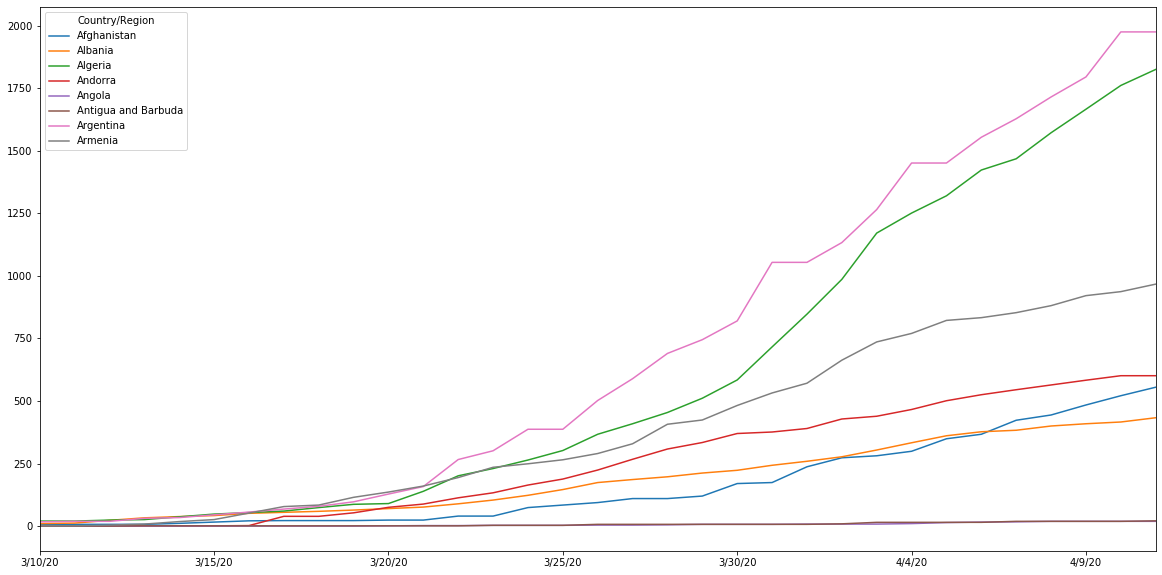

In [9]:
plt.rcParams['figure.figsize'] = [20, 10]
data.iloc[:8].T.iloc[50:].plot()

# Обрабатываем данные

## Представляем данные в виде, где каждой дате соответствует свой столбец

In [10]:
data2 = data.iloc[:,4:].stack().reset_index()
data2.columns = ["countries","date","confirmed"]

#Соединим смерти и заражения
data2 = data2.merge(data_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))

#Объединим с будущим
data2 = pd.concat([data2, data_ans],ignore_index=True)

#Добавим информацию о стране(плотность, население и тд)
data2 = data2.merge(countries, how = 'right', left_on='countries', right_on='countries')

#Удалим дни без больных
data2 = data2[data2.confirmed != 0]

/home/cv/miniconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Добавляем признак, количество дней от первого зараженного

In [11]:
# Считаем дни от первого больного
data2["date"] = pd.to_datetime(data2.date)
#data2 = data2[(data2["date"]<pd.to_datetime("2020-05-1")) & ((data2["date"]>pd.to_datetime("2020-04-1")) | (data2.confirmed !=-1))]
data4 = data2[["countries","date"]].groupby("countries").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2["days"] = (data2.date - data2.Date_min).dt.days
data2["days_mart"] = (data2.date - pd.to_datetime("2020-03-1")).dt.days
data2["days_after_Quarantine"] = (data2.date - pd.to_datetime(data2.Quarantine)).dt.days
data2.drop(['Date_min'], axis='columns',inplace=True)
data2.date = data2["date"].apply(lambda x: pd.Series(x.strftime("%m-%d")))
#data2 = data2.dropna(axis='index', how='any')
data2

,confirmed,countries,date,deaths,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,days,days_mart,days_after_Quarantine
0,1,Afghanistan,02-24,0,AFG,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-04-30,0,-6,-66
1,1,Afghanistan,02-25,0,AFG,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-04-30,1,-5,-65
2,1,Afghanistan,02-26,0,AFG,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-04-30,2,-4,-64
3,1,Afghanistan,02-27,0,AFG,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-04-30,3,-3,-63
4,1,Afghanistan,02-28,0,AFG,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-04-30,4,-2,-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,-1,Zimbabwe,12-27,-1,ZWE,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,2020-03-30,282,301,272
8129,-1,Zimbabwe,12-28,-1,ZWE,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,2020-03-30,283,302,273
8130,-1,Zimbabwe,12-29,-1,ZWE,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,2020-03-30,284,303,274
8131,-1,Zimbabwe,12-30,-1,ZWE,38,3.6,386850,19.0,-116858.0,14862924,0.38,0.0019,2020-03-30,285,304,275


## Добавить данные за прошлый день

In [12]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values
data2["pred_deaths"] = old_con2.values
data2 = data2.iloc[1:]
data2["delta_conf1"] = old_con.values[1:] - old_con.values[:-1]
data2["delta_deaths1"] = old_con2.values[1:] - old_con2.values[:-1]
data2 = data2.iloc[1:]
data2["delta_conf2"] = old_con.values[2:] - old_con.values[:-2]
data2["delta_deaths2"] = old_con2.values[2:] - old_con2.values[:-2]
data2[data2.iso_alpha3 == "RUS"].iloc[50:70]

/home/cv/miniconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/cv/miniconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,confirmed,countries,date,deaths,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,...,Quarantine,days,days_mart,days_after_Quarantine,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2
6143,306,Russia,03-21,1,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,50,20,-9,253,1,54,0,106,1
6144,367,Russia,03-22,1,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,51,21,-8,306,1,53,0,107,0
6145,438,Russia,03-23,1,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,52,22,-7,367,1,61,0,114,0
6146,495,Russia,03-24,1,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,53,23,-6,438,1,71,0,132,0
6147,658,Russia,03-25,3,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,54,24,-5,495,1,57,0,128,0
6148,840,Russia,03-26,3,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,55,25,-4,658,3,163,2,220,2
6149,1036,Russia,03-27,4,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,56,26,-3,840,3,182,0,345,2
6150,1264,Russia,03-28,4,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,57,27,-2,1036,4,196,1,378,1
6151,1534,Russia,03-29,8,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,58,28,-1,1264,4,228,0,424,1
6152,1836,Russia,03-30,9,RUS,9,1.8,16376870,40.0,182456.0,...,2020-03-30,59,29,0,1534,8,270,4,498,4


# Отделяем данные на трейн и тест

In [79]:
#Выберите день начала приватных данных начиная с 1 марта
days_x = 42
model_Confirmed, model_Death = {}, {}

log_labels = False

#Удаляем ненужные фичи
#data3 = data2.drop(['Quarantine','world_share','urban_pop_rate','population', 'migrants','median_age','land_area','fertility_rate','density','delta_deaths2','delta_deaths1','pred_deaths','date','Date_min'], axis='columns')
data3 = data2.drop(['Quarantine','world_share', 'migrants','median_age','land_area','fertility_rate','density','date'], axis='columns')
#data3 = data2.drop(['Quarantine','delta_deaths2','delta_deaths1','pred_deaths','date','Date_min'], axis='columns')
data3.population = data3.population/10**6

#Представляем страны в one_hot
#one_hot = pd.get_dummies(data3['iso_alpha3'])
#data3 = data3.join(one_hot)

#Отделяем пару стран на тест
data_Korea = data3[(data3.countries == 'Korea, South') & (data3.confirmed > 0)]
data_Russia = data3[(data3.countries == 'Russia') & (data3.confirmed > 0)]

#Приватные данные
new_data = data3[data2.days_mart >= days_x - 1]
old_data = data3[data2.days_mart < days_x]
old_data = old_data[(old_data.countries != 'Russia')&(old_data.countries != 'Korea, South')]

#Логорифмируем предсказания
#old_data["confirmed"] = log(old_data.confirmed) 

#Убираем ответ из данных
train_labels = old_data.confirmed
train_death = old_data.deaths
train_data = old_data.drop(['iso_alpha3','confirmed','countries','deaths'], axis='columns')
train_data

,population,urban_pop_rate,days,days_mart,days_after_Quarantine,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2
3,38.928346,0.25,3,-3,-63,1,0,0,0,0,0
4,38.928346,0.25,4,-2,-62,1,0,0,0,0,0
5,38.928346,0.25,5,-1,-61,1,0,0,0,0,0
6,38.928346,0.25,6,0,-60,1,0,0,0,0,0
7,38.928346,0.25,7,1,-59,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8121,14.862924,0.38,18,37,8,10,1,1,0,1,0
8122,14.862924,0.38,19,38,9,11,2,1,1,2,1
8123,14.862924,0.38,20,39,10,11,3,0,1,1,2
8124,14.862924,0.38,21,40,11,11,3,0,0,0,1


# Предсказываем и строим графики

## Логорифмируем ли предсказания?

In [80]:
log_labels = True
train_labels = np.log10(train_labels+1)
train_death = np.log10(train_death+1)

## Функция. Строим график и считаем MALE ошибку

In [81]:
def pred_score(models, data, death = False, plot = 0):
  predictions_all = 0
  plt.rcParams['figure.figsize'] = [20, len(models)*10]
  data = data[(data.confirmed > 0)]
  death_labels  = data.deaths
  labels = data.confirmed
  data = data.drop(['iso_alpha3','confirmed','countries','deaths'], axis='columns')  
  for i, model in enumerate(models):
    if model == "reg":
      predictions = models[model].predict(scaler.transform(data))
    else:
      predictions = models[model].predict(data)
    if log_labels:
      predictions = 10**predictions - 1
    predictions_all = predictions_all + predictions
    if death:
      print("Ошибка MALE по смертям", model, np.mean(np.abs(np.log10((predictions+1)/(death_labels+1)))))
    else:
      print("Ошибка MALE по заражениям", model, np.mean(np.abs(np.log10((predictions+1)/(labels+1)))))
    if plot:
      plt.subplot(len(models), 1, i+1)
      if plot==1:
        plt.plot(predictions, label = "Предсказанное значение") 
        if death:
          plt.plot(death_labels.values, label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.plot(labels.values, label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')
      if plot==2:
        plt.scatter(np.arange(0,len(predictions),1), predictions, s = 1, label = "Предсказанное значение") 
        if death:
          plt.scatter(np.arange(0,len(predictions),1), death_labels.values, s = 1,  label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.scatter(np.arange(0,len(predictions),1), labels.values, s = 1,  label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')      
      plt.title(model)
      plt.grid(True)
      plt.legend() 
  predictions_all = predictions_all/len(models)
  if death:
    print("Ошибка MALE по смертям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(death_labels+1)))))
  else:
    print("Ошибка MALE по заражениям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(labels+1)))))      

# Модели

## Исправить! Обучаем Линейная регрессия

In [82]:
"""
# Масштабируем данные?
scaler_data = True
train_data_scaler = train_data
if scaler_data:
  scaler = preprocessing.StandardScaler()
  scaler.fit(train_data)
  train_data_scaler = scaler.transform(train_data)

model_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_labels)
model_Death["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_death)
"""

'\n# Масштабируем данные?\nscaler_data = True\ntrain_data_scaler = train_data\nif scaler_data:\n  scaler = preprocessing.StandardScaler()\n  scaler.fit(train_data)\n  train_data_scaler = scaler.transform(train_data)\n\nmodel_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_labels)\nmodel_Death["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_death)\n'

## Обучаем Adaboost Regressor

In [83]:
treeDepth = 10
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.1, 0.01, 0.001]
                }
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
model_Confirmed["Adaboost"] = model_selection.RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid, n_iter = 100, 
                                         cv = 3, verbose=0, random_state=42, n_jobs = -1).fit(train_data, train_labels)
model_Death["Adaboost"] = model_selection.RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid, n_iter = 100, 
                                         cv = 3, verbose=0, random_state=42, n_jobs = -1).fit(train_data, train_death)

/home/cv/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/cv/miniconda3/envs/covid/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


## Обучаем случайный лес

In [84]:
model_Confirmed["RandomForest"]  = ensemble.RandomForestRegressor(n_estimators=1000, max_depth=30).fit(train_data, train_labels)
model_Death["RandomForest"] = ensemble.RandomForestRegressor(n_estimators=1000, max_depth=30).fit(train_data, train_death)

## Обучаем xgboost

In [85]:
model_Confirmed["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000).fit(train_data, train_labels)
model_Death["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000).fit(train_data, train_death)

## Обучаем свою модель

In [86]:
#model_Confirmed["new"] = 
#model_Death["new"] = 

# Считаем ошибку строим графики

## Удаляем ненужные модели

In [87]:
#del model_Confirmed["Ridge"] 
#del model_Death["Ridge"] 

##Настройки

In [88]:
# Данные new_data - новые с дня Х, 
# data_Russia - Данные по России
# data_Korea  - Данные по Франции
data_pred = data_Russia 

# Тип графика 0 - без графика
# 1 - plot
# 2 - scatter
plot_type = 1

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  model = model_Death
else:
  model = model_Confirmed

## Строим и считаем MALE 

Ошибка MALE по заражениям Adaboost 0.04857552518833131
Ошибка MALE по заражениям RandomForest 0.06108881751409904
Ошибка MALE по заражениям Xgboost 0.09261458536520457
Ошибка MALE по заражениям средняя 0.06684231839122187


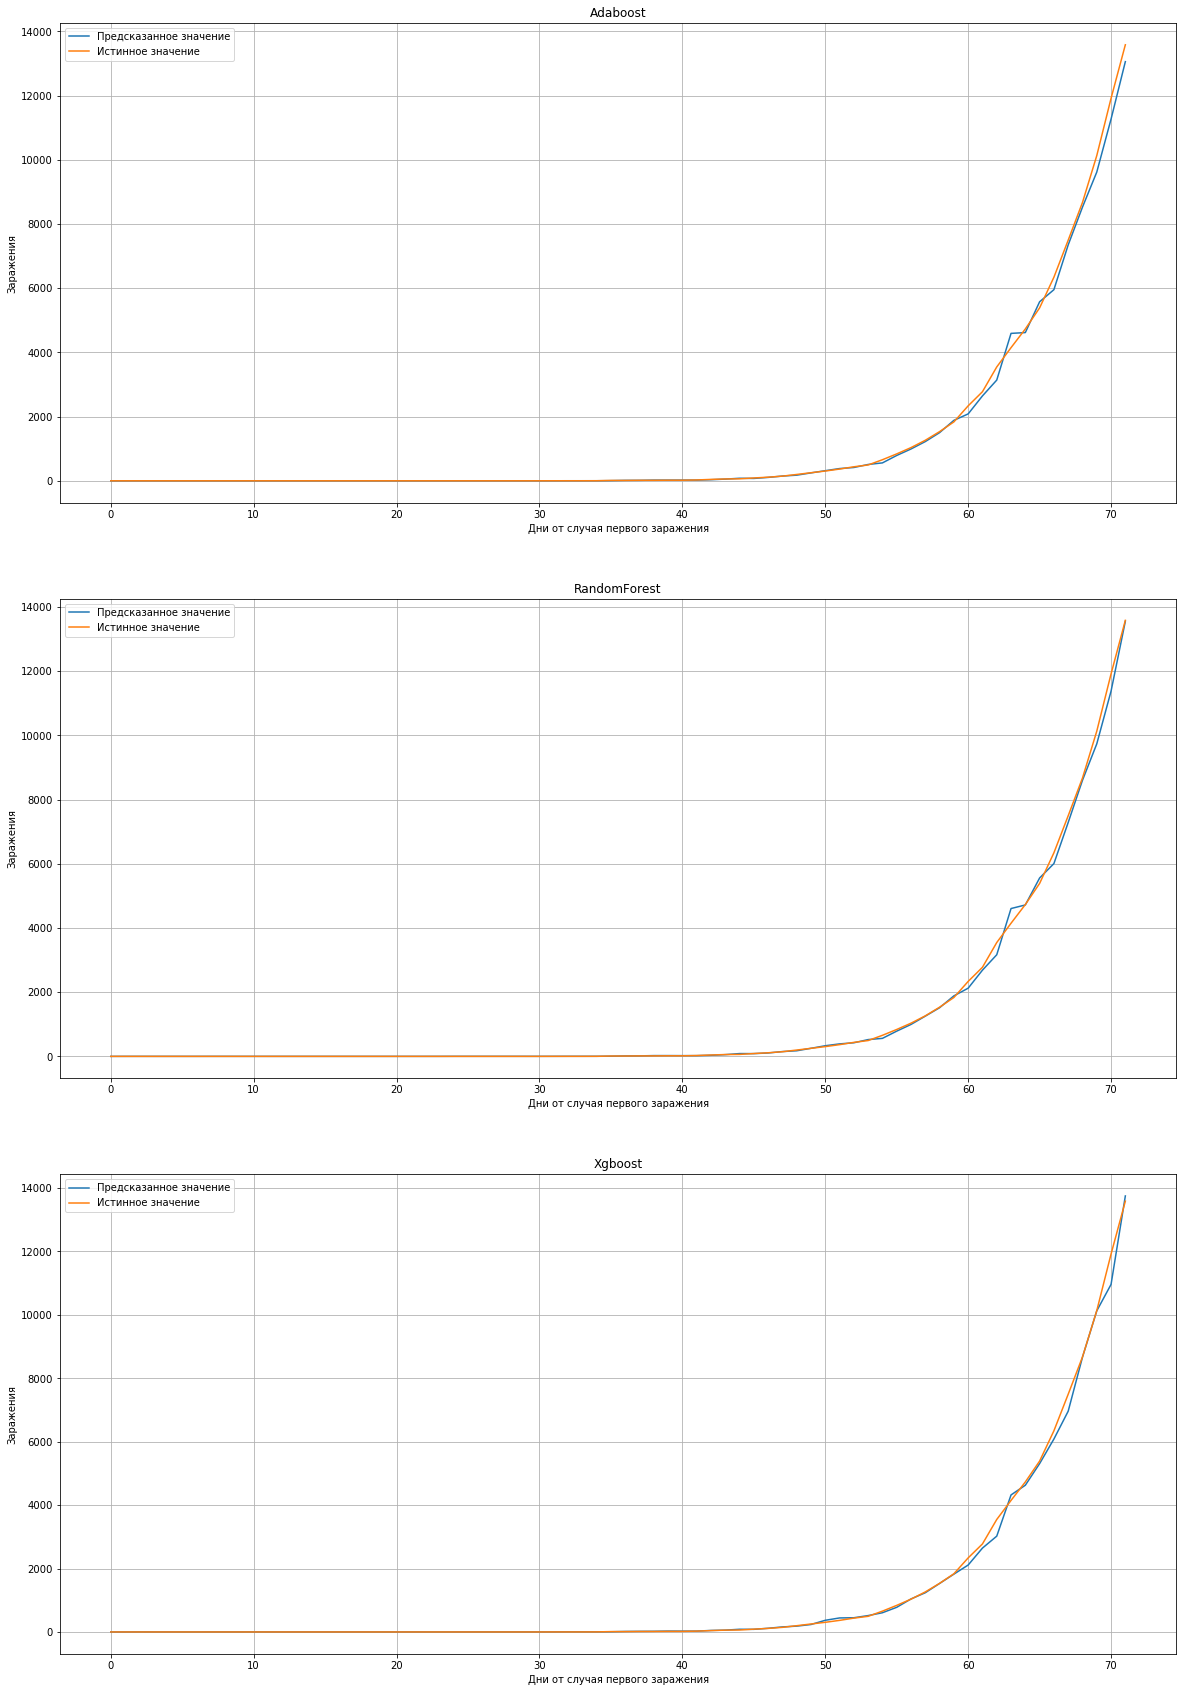

In [89]:
pred_score(model, data_pred, death_bool, plot_type)

#Предсказываем новые данные

In [90]:
# Сколько дней прогнозируем?
days_prog = 272

Matrix_confirmed,Matrix_Death ={},{}
for model_name in model_Confirmed:
  new_data_list = new_data[new_data.days_mart == days_x - 1]
  labels = new_data_list.iso_alpha3
  predictions_confirmed = [new_data_list.pred_conf.tolist()]
  predictions_Death = [new_data_list.pred_deaths.tolist()]  
  new_data_list = new_data_list.drop(['iso_alpha3','confirmed','countries','deaths'], axis='columns')
  for _ in range(days_prog):
    #print(data.iloc[-10:-7,-5:])
    prediction_confirmed = model_Confirmed[model_name].predict(new_data_list)
    prediction_Death = model_Death[model_name].predict(new_data_list)
    if log_labels:
      prediction_Death = 10**prediction_Death - 1
      prediction_confirmed = 10**prediction_confirmed - 1
    bad_confirmed = prediction_confirmed<new_data_list["pred_conf"]
    prediction_confirmed[bad_confirmed] = new_data_list[bad_confirmed]["pred_conf"]+np.round(new_data_list[bad_confirmed]["delta_conf1"]*0.9)
    bad_Death = prediction_Death<new_data_list["pred_deaths"]
    prediction_Death[bad_Death] = new_data_list[bad_Death]["pred_deaths"]+np.round(new_data_list[bad_Death]["delta_deaths1"]*0.9)
    new_data_list["delta_conf2"] = new_data_list["delta_conf1"]
    new_data_list["delta_conf1"] = prediction_confirmed - new_data_list["pred_conf"] 
    new_data_list["pred_conf"] = prediction_confirmed

    new_data_list["delta_deaths2"] = new_data_list["delta_deaths1"]
    new_data_list["delta_deaths1"] = prediction_Death - new_data_list["pred_deaths"] 
    #data[data["delta_conf1"] < 0].loc[:,"delta_conf1"] = 0
    new_data_list["pred_deaths"] = prediction_Death  

    new_data_list[["days_mart", "days"]] += 1

    predictions_Death.append(np.round(prediction_Death))
    predictions_confirmed.append(np.round(prediction_confirmed))
  data_list = pd.date_range('2020-04-'+str(days_x-32), periods = days_prog+1, freq ='d')
  data_list = data_list.strftime('%#m-%#d') 
  Matrix_confirmed[model_name] = pd.DataFrame(predictions_confirmed,columns = labels,index = data_list)
  Matrix_Death[model_name] = pd.DataFrame(predictions_Death,columns = labels,index = data_list)
Matrix_confirmed["Среднее"] = (Matrix_confirmed["Xgboost"] + Matrix_confirmed["RandomForest"] + Matrix_confirmed["Adaboost"])//3
Matrix_Death["Среднее"] = (Matrix_Death["Xgboost"] + Matrix_Death["RandomForest"] + Matrix_Death["Adaboost"])//3

## Функция отображения данных

In [91]:
def plot_new(list_countries, Matrix, Death = False,subplot_x = 2):
  plt.rcParams['figure.figsize'] = [20, len(list_countries)*20/subplot_x**2]
  for i, Country in enumerate(list_countries):
    plt.subplot(len(list_countries)// subplot_x + 1, subplot_x, i+1)
    yyy = data2[(data2.iso_alpha3 == Country)&(data2.confirmed>0)&(data2.days_mart>=days_x - 10)]
    if Death:
      plt.plot(yyy.date, yyy.deaths, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Смерти')
    else:
      plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Заражения')
    for name in Matrix:
      yyy2 = Matrix[name][[Country]]
      plt.plot(yyy2, label = name)
    plt.title(dic_countries[Country])
    plt.xticks(np.arange(0, (10+days_prog), ((10+days_prog)//14)*subplot_x))
    #plt.yticks(np.linspace(0,10+days_prog,30//subplot_x))
    plt.grid(True)
    plt.legend()

## Настройки

In [92]:
"""del Matrix_Death["Xgboost"] 
del Matrix_Death["Xgboost"] 
del Matrix_confirmed["RandomForest"] 
del Matrix_confirmed["RandomForest"] """

'del Matrix_Death["Xgboost"] \ndel Matrix_Death["Xgboost"] \ndel Matrix_confirmed["RandomForest"] \ndel Matrix_confirmed["RandomForest"] '

In [93]:
# Создаём список стран
list_countries = countries.iso_alpha3.to_list()[60:66]
#list_countries = []
list_countries.extend(["RUS","FRA","ITA"])

# Количество графиков в строке
subplot_x = 2

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  Matrix = Matrix_Death
else:
  Matrix = Matrix_confirmed

## Строим график

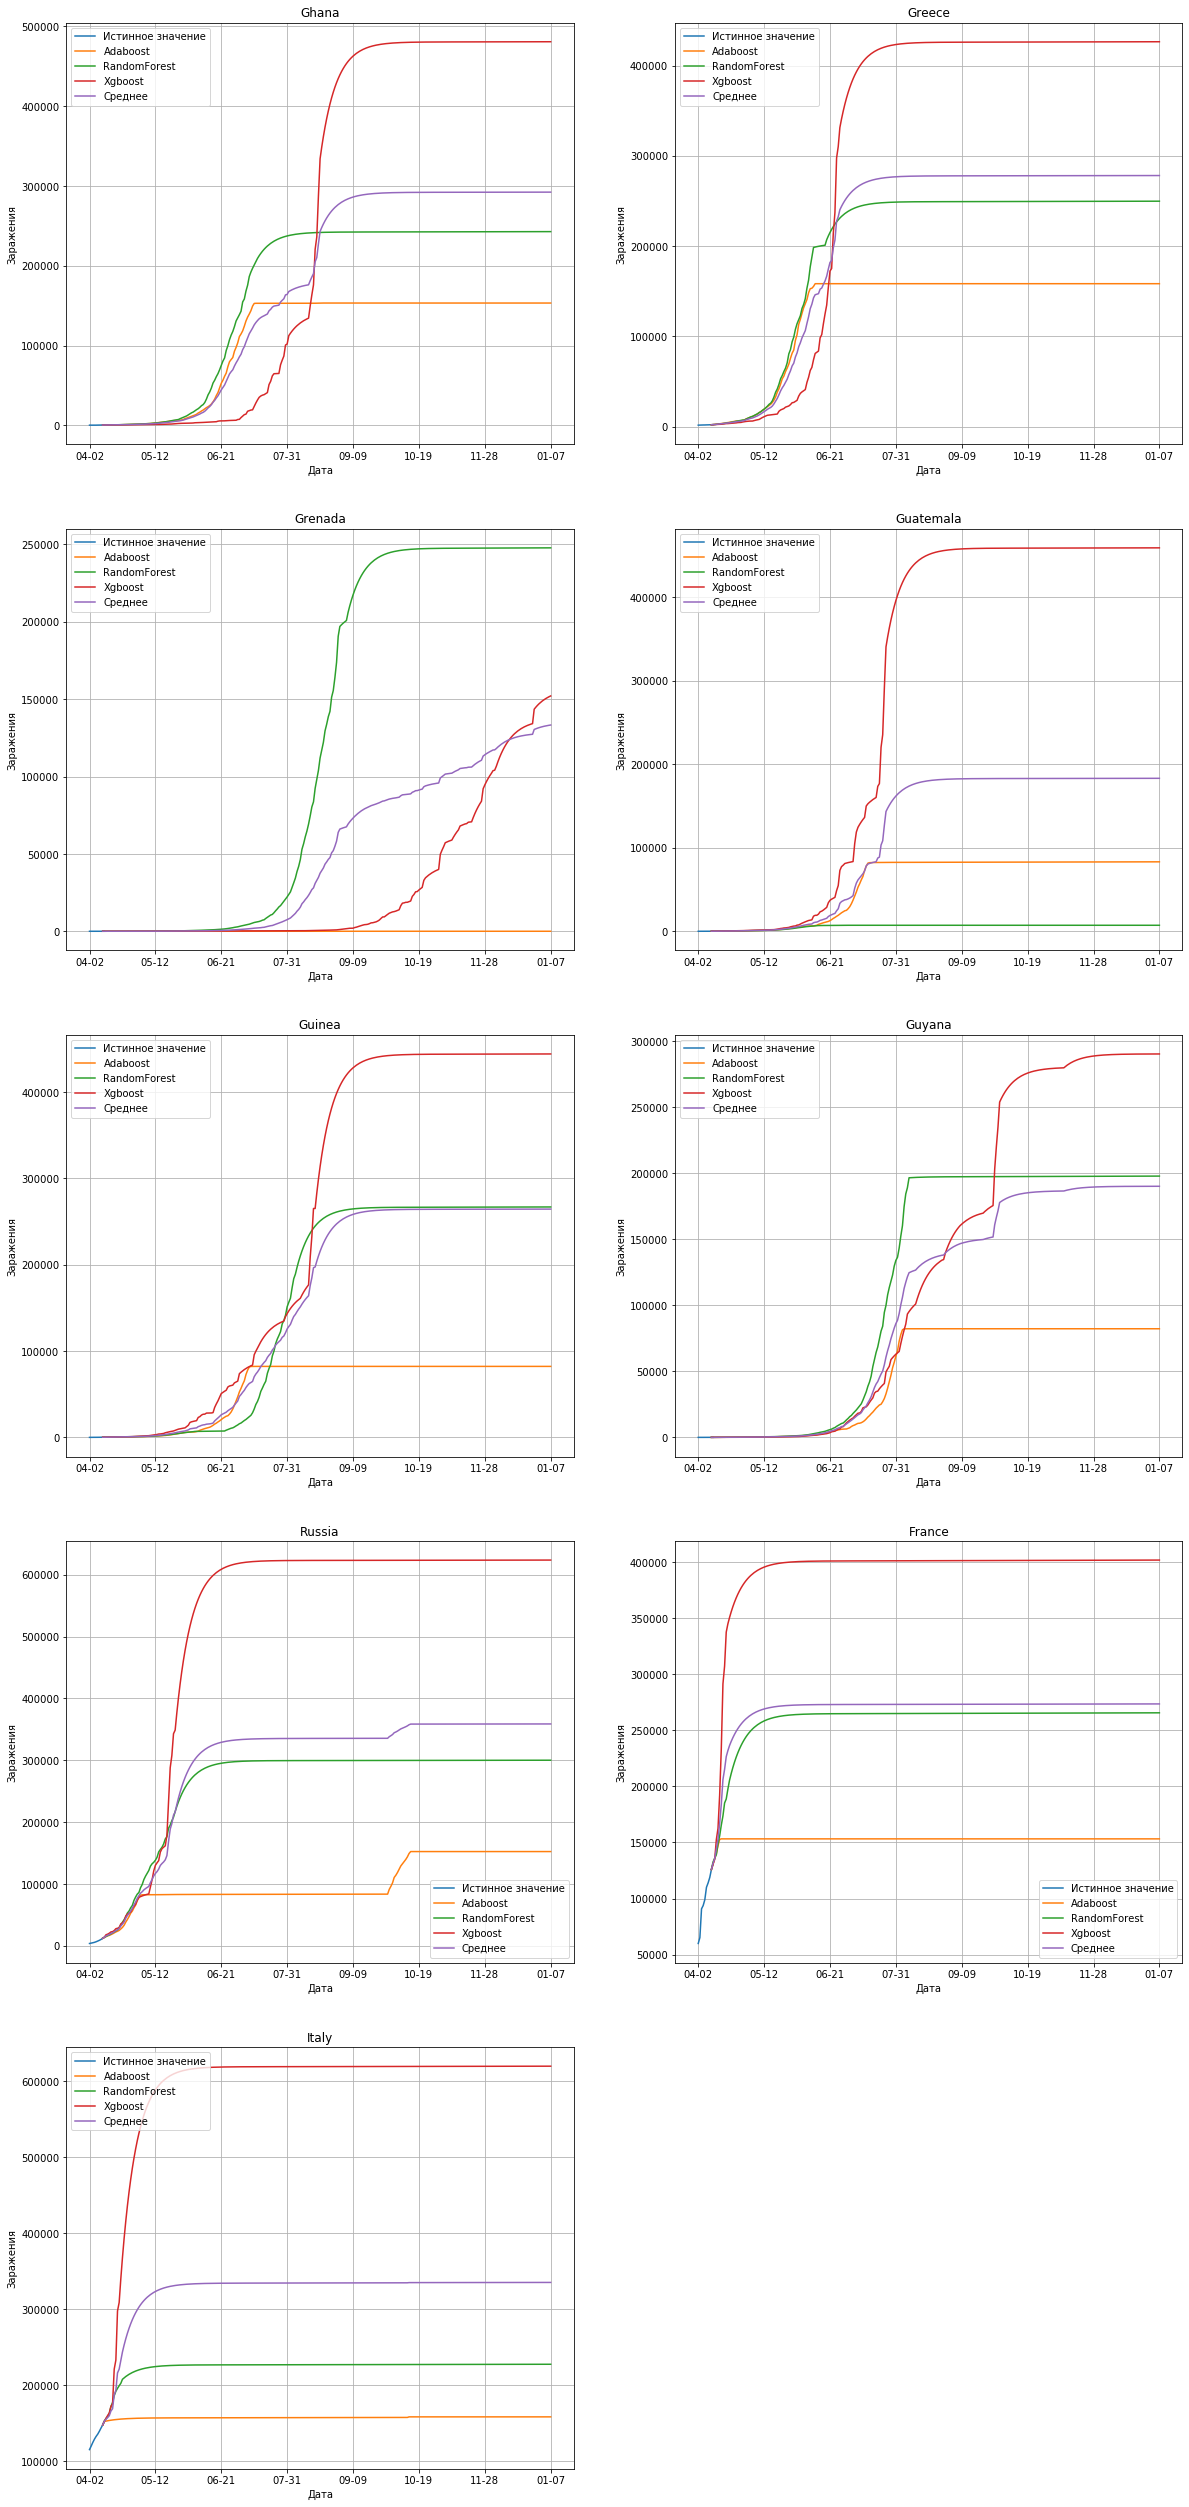

In [94]:
plot_new(list_countries,Matrix,death_bool,subplot_x)

# Сохраняем прогноз

In [95]:
Matrix_confirmed

{'Adaboost': iso_alpha3       AFG      ALB       DZA       AND      AGO   ATG       ARG  \
 04-10          521.0    416.0    1761.0     601.0     19.0  19.0    1975.0   
 04-11          565.0    443.0    1839.0     618.0     20.0  20.0    2047.0   
 04-12          597.0    473.0    1949.0     633.0     21.0  20.0    2223.0   
 04-13          622.0    495.0    2044.0     663.0     24.0  20.0    2420.0   
 04-14          644.0    523.0    2231.0     718.0     28.0  20.0    2619.0   
 ...              ...      ...       ...       ...      ...   ...       ...   
 01-03       153222.0  82601.0  152271.0  194308.0  83271.0  20.0  181885.0   
 01-04       153222.0  82602.0  152271.0  194312.0  83275.0  20.0  181889.0   
 01-05       153222.0  82603.0  152271.0  194316.0  83279.0  20.0  181893.0   
 01-06       153222.0  82604.0  152271.0  194320.0  83283.0  20.0  181897.0   
 01-07       153222.0  82605.0  152271.0  194324.0  83287.0  20.0  181901.0   
 
 iso_alpha3       ARM       AUS       

In [116]:
sample_sub = pd.read_csv("sample_submission.csv")

In [117]:
sample_sub = sample_sub.set_index(['date', 'country'])

In [123]:
ans = Matrix_confirmed["Среднее"].stack().reset_index()
ans_Death = Matrix_Death["Среднее"].stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans.columns = ['date','country','prediction_confirmed', 'prediction_deaths']
ans['date'] = pd.to_datetime('2020-'+ans['date']).astype("str")
ans['prediction_confirmed'] = ans['prediction_confirmed'].astype('int')
ans['prediction_deaths'] = ans['prediction_deaths'].astype('int')

In [124]:
ans = ans.sort_values(by=['country', 'date'])
ans = ans.set_index(['date', 'country'])

In [125]:
ans

,,prediction_confirmed,prediction_deaths
date,country,,
2020-01-01,AFG,406732,20351
2020-01-02,AFG,406735,20354
2020-01-03,AFG,406737,20357
2020-01-04,AFG,406740,20359
2020-01-05,AFG,406743,20362
...,...,...,...
2020-12-27,ZWE,167794,22484
2020-12-28,ZWE,167796,22487
2020-12-29,ZWE,167799,22490


In [126]:
sample_sub

,,prediction_confirmed,prediction_deaths
date,country,,
2020-04-05,AFG,396.0,7.0
2020-04-06,AFG,449.0,8.0
2020-04-07,AFG,510.0,10.0
2020-04-08,AFG,579.0,11.0
2020-04-09,AFG,658.0,12.0
...,...,...,...
2020-12-27,ZWE,152904.0,4365.0
2020-12-28,ZWE,152904.0,4365.0
2020-12-29,ZWE,152904.0,4365.0


In [129]:
sample_sub.update(ans)


,,prediction_confirmed,prediction_deaths
date,country,,
2020-04-05,AFG,396.0,7.0
2020-04-06,AFG,449.0,8.0
2020-04-07,AFG,510.0,10.0
2020-04-08,AFG,579.0,11.0
2020-04-09,AFG,658.0,12.0
...,...,...,...
2020-12-27,ZWE,167794.0,22484.0
2020-12-28,ZWE,167796.0,22487.0
2020-12-29,ZWE,167799.0,22490.0


In [132]:
sample_sub

,,prediction_confirmed,prediction_deaths
date,country,,
2020-04-05,AFG,396,7.0
2020-04-06,AFG,449,8.0
2020-04-07,AFG,510,10.0
2020-04-08,AFG,579,11.0
2020-04-09,AFG,658,12.0
...,...,...,...
2020-12-27,ZWE,167794,22484.0
2020-12-28,ZWE,167796,22487.0
2020-12-29,ZWE,167799,22490.0


In [133]:
sample_sub["prediction_confirmed"] = sample_sub["prediction_confirmed"].astype('int')
sample_sub["prediction_deaths"] = sample_sub["prediction_deaths"].astype('int')

In [134]:
sample_sub.to_csv('submission_mean.csv', index=True)

In [135]:
ans = Matrix_confirmed['Adaboost'].stack().reset_index()
ans_Death = Matrix_Death['Adaboost'].stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans.columns = ['date','country','prediction_confirmed', 'prediction_deaths']
ans['date'] = pd.to_datetime('2020-'+ans['date']).astype("str")
ans['prediction_confirmed'] = ans['prediction_confirmed'].astype('int')
ans['prediction_deaths'] = ans['prediction_deaths'].astype('int')
ans = ans.sort_values(by=['country', 'date'])
ans = ans.set_index(['date', 'country'])
sample_sub.update(ans)
sample_sub["prediction_confirmed"] = sample_sub["prediction_confirmed"].astype('int')
sample_sub["prediction_deaths"] = sample_sub["prediction_deaths"].astype('int')
sample_sub.to_csv('submission_ada.csv', index=True)

In [136]:
sample_sub.head(100)

,,prediction_confirmed,prediction_deaths
date,country,,
2020-04-05,AFG,396,7
2020-04-06,AFG,449,8
2020-04-07,AFG,510,10
2020-04-08,AFG,579,11
2020-04-09,AFG,658,12
...,...,...,...
2020-07-09,AFG,153222,16606
2020-07-10,AFG,153222,18279
2020-07-11,AFG,153222,18849


In [111]:
ans.head(100)

,,prediction_confirmed,prediction_deaths
date,country,,
2020-01-01,AFG,153222,19468
2020-01-02,AFG,153222,19468
2020-01-03,AFG,153222,19468
2020-01-04,AFG,153222,19468
2020-01-05,AFG,153222,19468
...,...,...,...
2020-07-07,AFG,152746,15447
2020-07-08,AFG,152841,16081
2020-07-09,AFG,153222,16606


In [121]:
sample_sub.update(ans,overwrite=True)